In [1]:
%matplotlib notebook
# use ``%matplotlib widget`` in Jupyter Lab

In [2]:
from collections import namedtuple  # optional, for grouping input parameters
import numpy as np
import unyt as u  # for physical units support
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import figformat 
fig_width,fig_height,params=figformat.figure_format(fig_width=3.4*2)
mpl.rcParams.update(params)
from prepic import GaussianBeam
from prepic import Laser
from prepic import Plasma
from prepic import Simulation

In [3]:
ne = 5.307e18 # electron plasma density
flat_top_dist = 1.0 # plasma flat top distance (mm)
Flame = namedtuple(
     "Flame",
    [
        "npe",  # electron plasma density
         "w0",  # laser beam waist (Gaussian beam assumed)
         "ɛL",  # laser energy on target (focused into the FWHM@intensity spot)
         "τL",  # laser pulse duration (FWHM@intensity)
         "prop_dist",  # laser propagation distance (acceleration length)
     ],
    )
param = Flame(
     npe = ne / u.cm ** 3,
     w0 = 18.7 * u.micrometer,
     ɛL = 1.8 * u.joule,
     τL = 25 * u.femtosecond,
     prop_dist = flat_top_dist * u.mm,
    )

flame_beam = GaussianBeam(w0 =param.w0)
flame_laser = Laser(ɛL=param.ɛL, τL=param.τL, beam=flame_beam)
flame_plasma = Plasma(
    n_pe=param.npe, 
    laser=flame_laser, 
    propagation_distance=param.prop_dist
    )
sim_flame = Simulation(flame_plasma,box_length=97*u.micrometer,ppc=2)

In [4]:
print(flame_beam)
print(flame_laser) 
print(f"critical density for this laser is {flame_laser.ncrit:.1e}")
print(flame_plasma)
print(sim_flame)

beam with w0=18.7 µm (FWHM=22.0 µm), zᵣ=1.37 mm, λL=0.80 µm
laser with kL=7.854 1/µm, ωL=2.355 1/fs, ɛL=1.8 J, τL=25.0 fs, P₀=67.6 TW
I₀=1.2e+19 W/cm**2, a₀=2.4, E₀=9.6e+03 MV/mm
Helium ionization state: 2+
critical density for this laser is 1.7e+21 cm**(-3)
Plasma with nₚ=5.3e+18 cm**(-3) (3.05e-03 × nc), ωₚ=0.130 1/fs, kₚ=0.434 1/µm, λₚ=14.5 µm, Ewb=221.5 MV/mm
Pc=5.6 TW, Ldeph=1.56 mm, Ldepl=2.46 mm, ΔE=171.6 MeV over Lacc=1.00 mm
3D simulation with box size (97.0 µm)³, Δx=0.231 µm, Δy=0.231 µm, Δz=0.040 µm, nx=420, ny=420, nz=2425, 8.555400e+08 macro-particles, 2.742400e+04 time steps


# Create & plot a plasma density profile with a flat top and Gaussian ramps to either side.
https://gist.github.com/berceanu/b51318f1f90d63678cad99ed6d154a8b 

<IPython.core.display.Javascript object>


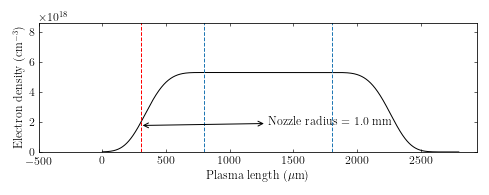

In [7]:
def dens_func(x, *, center_left, center_right, sigma_left, sigma_right, power):
    """Compute the (normalized) plasma density at position x."""
    
    def ramp(x, *, center, sigma, power):
        """Gaussian-like function."""
        
        return np.exp(-(((x - center) / sigma) ** power))

    # Allocate relative density
    n = np.ones_like(x)

    # before up-ramp
    n = np.where(x < 0, 0, n)

    # Make up-ramp
    n = np.where(
        x < center_left, ramp(x, center=center_left, sigma=sigma_left, power=power), n
    )

    # Make down-ramp
    n = np.where(
        (x >= center_right) & (x < center_right + 2 * sigma_right),
        ramp(x, center=center_right, sigma=sigma_right, power=power),
        n,
    )

    # after down-ramp
    n = np.where(x >= center_right + 2 * sigma_right, 0, n)

    return n


if __name__ == "__main__":
    ne = 5.307e18  # electron plasma density cm$^{-3}$
    gasPower = 4

    #  lengths in microns
    flat_top_dist = 1000  # plasma flat top distance
    gasCenterLeft_SI = 800
    gasCenterRight_SI = gasCenterLeft_SI + flat_top_dist
    gasSigmaLeft_SI = 500
    gasSigmaRight_SI = 500
    FOCUS_POS_SI = 300 #microns
    Nozzle_r = (gasCenterLeft_SI + gasCenterRight_SI) / 2 - FOCUS_POS_SI
    Nozzle_r = Nozzle_r*0.001

    all_x = np.linspace(0, gasCenterRight_SI + 2 * gasSigmaRight_SI, 3001)
    dens = dens_func(
        all_x,
        center_left=gasCenterLeft_SI,
        center_right=gasCenterRight_SI,
        sigma_left=gasSigmaLeft_SI,
        sigma_right=gasSigmaRight_SI,
        power=gasPower,
    )


    fig, ax = plt.subplots()

    ax.plot(all_x, ne * dens, color="black")

    ax.axvline(x=gasCenterLeft_SI, ymin=0, ymax=ne, linestyle="--")
    ax.axvline(x=gasCenterRight_SI, ymin=0, ymax=ne, linestyle="--")

    ax.axvline(x=FOCUS_POS_SI, ymin=0, ymax=ne, linestyle="--", color="red")

    ax.set_ylabel(r"Electron density (cm$^{-3}$)")
    ax.set_xlabel(r"Plasma length ($\mathrm{\mu m}$)")

    ax.annotate(
        r"Nozzle radius = %s $\mathrm{mm}$" % Nozzle_r,
        xy=(FOCUS_POS_SI, ne / 3),
        xycoords="data",
        xytext=((gasCenterLeft_SI + gasCenterRight_SI) / 2, ne / 3),
        textcoords="data",
        arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"),
    )

    ax.set_ylim(ymin=0,ymax=ne*1.618)
    ax.set_xlim(xmin=-500)
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_width*0.40)  
    plt.tight_layout()
    fig.savefig("density.eps",dpi=100, bbox_inches='tight')

In [8]:
plt.close('all')